In [48]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton

device = torch.device('cuda:0')
steps  = 101
pp   = torch.tensor(.8)
h    = torch.log(pp/(1-pp))/2
k    = 3
d    = 100000
bs   = 200
x    = torch.randn(d, bs, device=device)
xs   = [x]
inv_t  = 1.1
fp_eqn = lambda x: np.tanh(inv_t * x) - x 
m      = torch.tensor(newton(fp_eqn, 1))

tau  = lambda t: 2*k*t/d**(1/2) if t < 1/2 else k/d**(1/2) + (1-k/d**(1/2))*(2*t-1)
taup = lambda t: 2*k/d**(1/2) if t < 1/2 else (1-k/d**(1/2))*2

b_over_a = lambda t: tau(t) / (1-tau(t))**2
W_plus   = torch.exp(h * m) / (2 * torch.cosh(h * m))
W_minus  = torch.exp(-h * m) / (2 * torch.cosh(h * m))
logQp    = lambda x, t: torch.sum(torch.log(1 + m * torch.tanh(x * b_over_a(t))), 0)
logQm    = lambda x, t: torch.sum(torch.log(1 - m * torch.tanh(x * b_over_a(t))), 0)

def cond_exp(x, t):
    # Q_p > Q_m
    pgm = logQp(x, t) >= logQm(x, t)
    Q_mp = torch.exp((logQm(x, t) - logQp(x, t)) * pgm)
    num = W_plus * torch.tanh(inv_t * m + x * b_over_a(t))\
          + W_minus * Q_mp * torch.tanh(-inv_t * m + x * b_over_a(t)) 
    den = W_plus + W_minus * Q_mp
    eta_mp = num / den
    
    # Q_m > Q_p
    mgp = logQp(x, t) < logQm(x, t)
    Q_pm = torch.exp((logQp(x, t) - logQm(x, t)) * mgp)
    num = W_plus * Q_pm * torch.tanh(inv_t * m + x * b_over_a(t))\
          + W_minus * torch.tanh(-inv_t * m + x * b_over_a(t)) 
    den = W_plus * Q_pm + W_minus
    eta_pm = num / den

    # put together
    return eta_mp * pgm + eta_pm * mgp

bf = lambda x, t: taup(t) / (1-tau(t)) * (-x + cond_exp(x, t))

ts1   = torch.linspace(0, k/d**(1/2), steps//2+1)[:-1]
ts2   = torch.linspace(k/d**(1/2), 1, steps//2)
ts    = torch.cat((ts1, ts2))
ts    = torch.linspace(0, 1, steps)
logQps = []
approxs = []

for i, t in enumerate(ts[:-1]):
    if i % 10 == 0: print(t)
    dt = ts[i+1] - ts[i]
    x = x + bf(x, t) * dt
    logQps.append(logQp(x, t))
    approxs.append(x.sum(0) * m * tau(t) / (1-tau(t))**2)
    xs.append(x)

xs = torch.stack(xs)
logQps = torch.stack(logQps)
approxs = torch.stack(approxs)

tensor(0.)
tensor(0.1000)
tensor(0.2000)
tensor(0.3000)
tensor(0.4000)
tensor(0.5000)
tensor(0.6000)
tensor(0.7000)
tensor(0.8000)
tensor(0.9000)


In [49]:
logQps[:, 0].cpu() - logQps[:, 1].cpu()

tensor([ 0.0000e+00, -2.4025e-02, -4.8191e-02, -7.2498e-02, -9.6998e-02,
        -1.2172e-01, -1.4685e-01, -1.7225e-01, -1.9805e-01, -2.2433e-01,
        -2.5109e-01, -2.7836e-01, -3.0623e-01, -3.3467e-01, -3.6373e-01,
        -3.9345e-01, -4.2384e-01, -4.5485e-01, -4.8664e-01, -5.1905e-01,
        -5.5216e-01, -5.8589e-01, -6.2032e-01, -6.5536e-01, -6.9098e-01,
        -7.2717e-01, -7.6384e-01, -8.0103e-01, -8.3861e-01, -8.7655e-01,
        -9.1479e-01, -9.5329e-01, -9.9200e-01, -1.0308e+00, -1.0698e+00,
        -1.1087e+00, -1.1476e+00, -1.1865e+00, -1.2252e+00, -1.2638e+00,
        -1.3023e+00, -1.3405e+00, -1.3785e+00, -1.4163e+00, -1.4538e+00,
        -1.4911e+00, -1.5282e+00, -1.5650e+00, -1.6016e+00, -1.6380e+00,
        -1.8690e+00, -5.9578e+00, -1.0317e+01, -1.4970e+01, -1.9945e+01,
        -2.5274e+01, -3.0992e+01, -3.7141e+01, -4.3767e+01, -5.0925e+01,
        -5.8676e+01, -6.7091e+01, -7.6252e+01, -8.6253e+01, -9.7198e+01,
        -1.0919e+02, -1.2236e+02, -1.3679e+02, -1.5

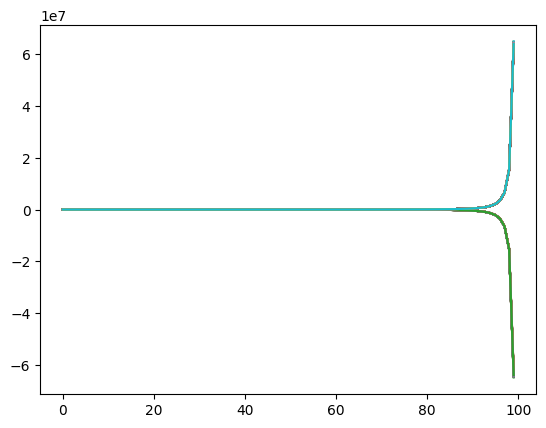

In [50]:
plt.plot(approxs.cpu());

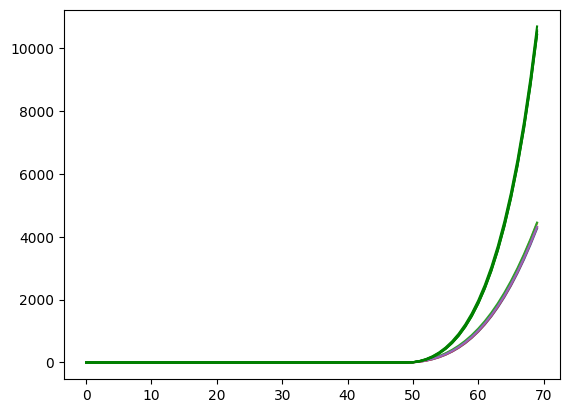

In [51]:
plt.plot(logQps[:70, :5].cpu());
plt.plot(approxs[:70, :5].cpu(), color='green');

/tmp/ipykernel_1374112/3333859704.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  x = np.array(xs[180, :, 0].cpu())


np.float32(0.7756752)

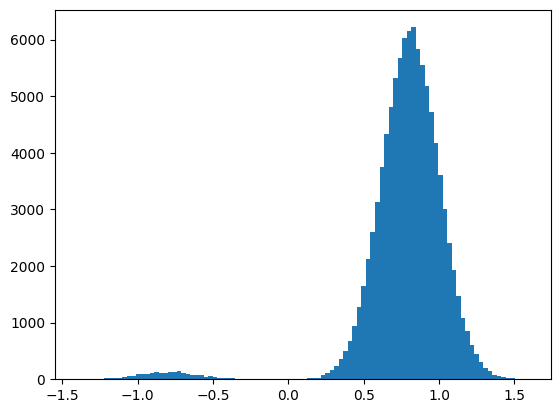

In [34]:
x = np.array(xs[180, :, 0].cpu())
plt.hist(x, bins=100)
np.mean(x)

In [2]:
ms = xs.mean(1).cpu().numpy()

In [3]:
(ms[-1] > 0).mean()

np.float64(0.785)

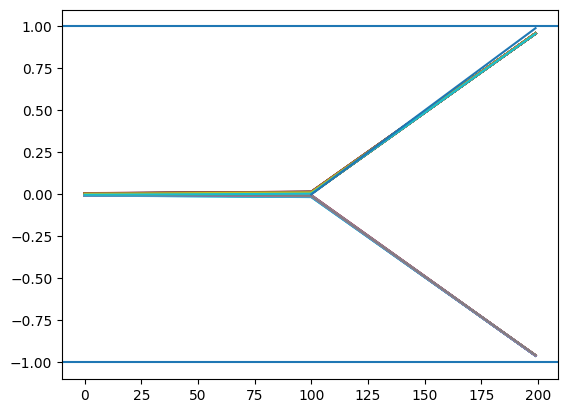

In [4]:
plt.plot(ms);
plt.axhline(1, 0, 200)
plt.axhline(-1, 0, 200)
aa = np.arange(100, 200, 1)
plt.plot(aa, aa/100 -1)

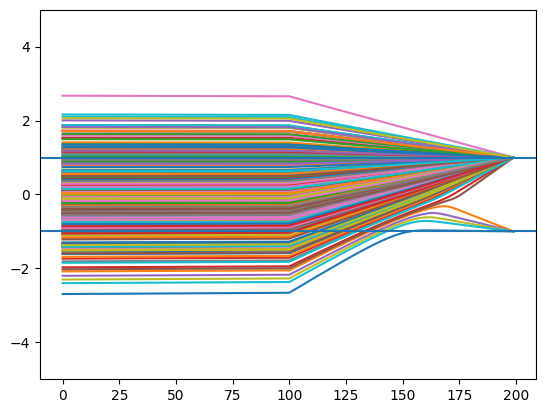

In [5]:
plt.plot(xs[:, :300, 1].cpu().numpy());
plt.ylim(-5,5)
plt.axhline(1, 0, 200)
plt.axhline(-1, 0, 200)

In [66]:
np.mean(xs[-1, :, 0].cpu().numpy() > 0)*2-1

np.float64(0.95112)

In [68]:
for i in range(steps): print(np.mean(xs[i, :, 0].cpu().numpy() > 0)*2-1)

-0.0019200000000000328
-0.0018799999999999928
-0.0015600000000000058
-0.0014399999999999968
-0.0013199999999999878
-0.0011200000000000099
-0.0009599999999999609
-0.0007599999999999829
-0.00048000000000003595
-0.00036000000000002697
-0.00012000000000000899
4.0000000000040004e-05
0.00015999999999993797
0.00043999999999999595
0.0005599999999998939
0.0007200000000000539
0.0009600000000000719
0.0012399999999999078
0.0014799999999999258
0.0019199999999999218
0.0023200000000000998
0.0029600000000000737
0.0033199999999999896
0.0036799999999999056
0.0040000000000000036
0.0043999999999999595
0.034319999999999906
0.06347999999999998
0.09396000000000004
0.1253200000000001
0.1559600000000001
0.18764000000000003
0.22076000000000007
0.25264
0.28635999999999995
0.31992
0.35627999999999993
0.39280000000000004
0.43096
0.47164000000000006
0.5140800000000001
0.5591200000000001
0.6064
0.6553199999999999
0.70932
0.76752
0.82264
0.8788800000000001
0.92252
0.94644
0.95112
